# Causality Discovery Toolbox PC algorithm

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

from notebooklib.save import run_tsdr, save_tsdr, load_tsdr, load_tsdr_by_chaos

In [4]:
from cdt.causality.graph import PC, GES
import networkx as nx

In [3]:
from meltria.priorknowledge.priorknowledge import SockShopKnowledge

pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [64]:
DATASET_ID = "9n6mf"
datasets_fluxrank_max_cluster = load_tsdr_by_chaos(
    DATASET_ID, suffix="fluxrank_max_cluster", revert_normalized_time_series=True,
)

In [44]:
def pagerank(cg: nx.DiGraph, record):
    pr = nx.pagerank(cg.reverse(), alpha=0.85, weight="weight")
    _records = []
    for metric_name, rank in pr.items():
        _records.append(
            (DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(), record.chaos_case_num(), str(metric_name), record.data_df[str(metric_name)].values, rank)
        )
    return _records

In [116]:
from diagnoser.diag import prepare_init_graph, fix_edge_directions_in_causal_graph, find_connected_subgraphs
import diagnoser.metric_node as mn

record, data_df_by_metric_type = datasets_fluxrank_max_cluster[("pod-cpu-hog", "carts")][1]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1],
    data_df_by_metric_type["services"][-1],
    # data_df_by_metric_type["middlewares"][-1],
], axis=1)
print(record.chaos_case_full())
nodes = mn.MetricNodes.from_metric_names(dataset.columns.tolist())
init_g = prepare_init_graph(nodes, pk)

carts/pod-cpu-hog/0


In [128]:
pc = PC(CItest="gaussian", alpha=0.05, method_indep="corr")
# cg = GES(score="obs").create_graph_from_init_graph(dataset, init_g)
cg = pc.create_graph_from_init_graph(dataset, init_g)
# cg = pc.predict(dataset)

KeyboardInterrupt: 

In [123]:
_cg = mn.relabel_graph_labels_to_node(cg)
root_contained_graphs, root_uncontained_graphs = find_connected_subgraphs(_cg, pk.get_root_metrics())
max_graph = max(root_contained_graphs, key=lambda g: len(g.nodes))
max_graph = fix_edge_directions_in_causal_graph(max_graph, pk)

In [124]:
from eval.groundtruth import check_causal_graph

ok, _ = check_causal_graph(pk=pk, G=max_graph, chaos_comp=record.chaos_comp(), chaos_type=record.chaos_type(), optional_cause=True)
ok

False

In [125]:
## similality
g = mn.relabel_graph_nodes_to_label(max_graph)
data = dataset.filter(list(g.nodes), axis=1)
front_root_metric = [m for m in data.columns.tolist() if m in pk.get_root_metrics()][0]
front_root_metric_id = data.columns.tolist().index(front_root_metric)
corr = np.corrcoef(data.values.T)
similarities_to_front = [abs(x) for x in corr[front_root_metric_id]]
rho = 0.1
for i in g.nodes:
    for j in g.nodes:
        s_i = similarities_to_front[list(g.nodes).index(i)]
        s_j = similarities_to_front[list(g.nodes).index(j)]
        # forward edge
        if g.has_edge(i, j):
            g.edges[i, j]["weight"] = abs(s_j)
        elif g.has_edge(j, i):
            g.add_edge(i, j, weight=rho * abs(s_i))

## self edge
for i in g.nodes:
    if i == front_root_metric:
        continue
    s_i: float = similarities_to_front[list(g.nodes).index(i)]
    p_i: list[float] = [g[i][j]["weight"] for j in g[i]]
    g.add_edge(i, i, weight=max(0, s_i - max(p_i)))

# teleportation_prob = (np.array(similarities_to_front) / np.sum(similarities_to_front)).tolist()
# print(teleportation_prob)

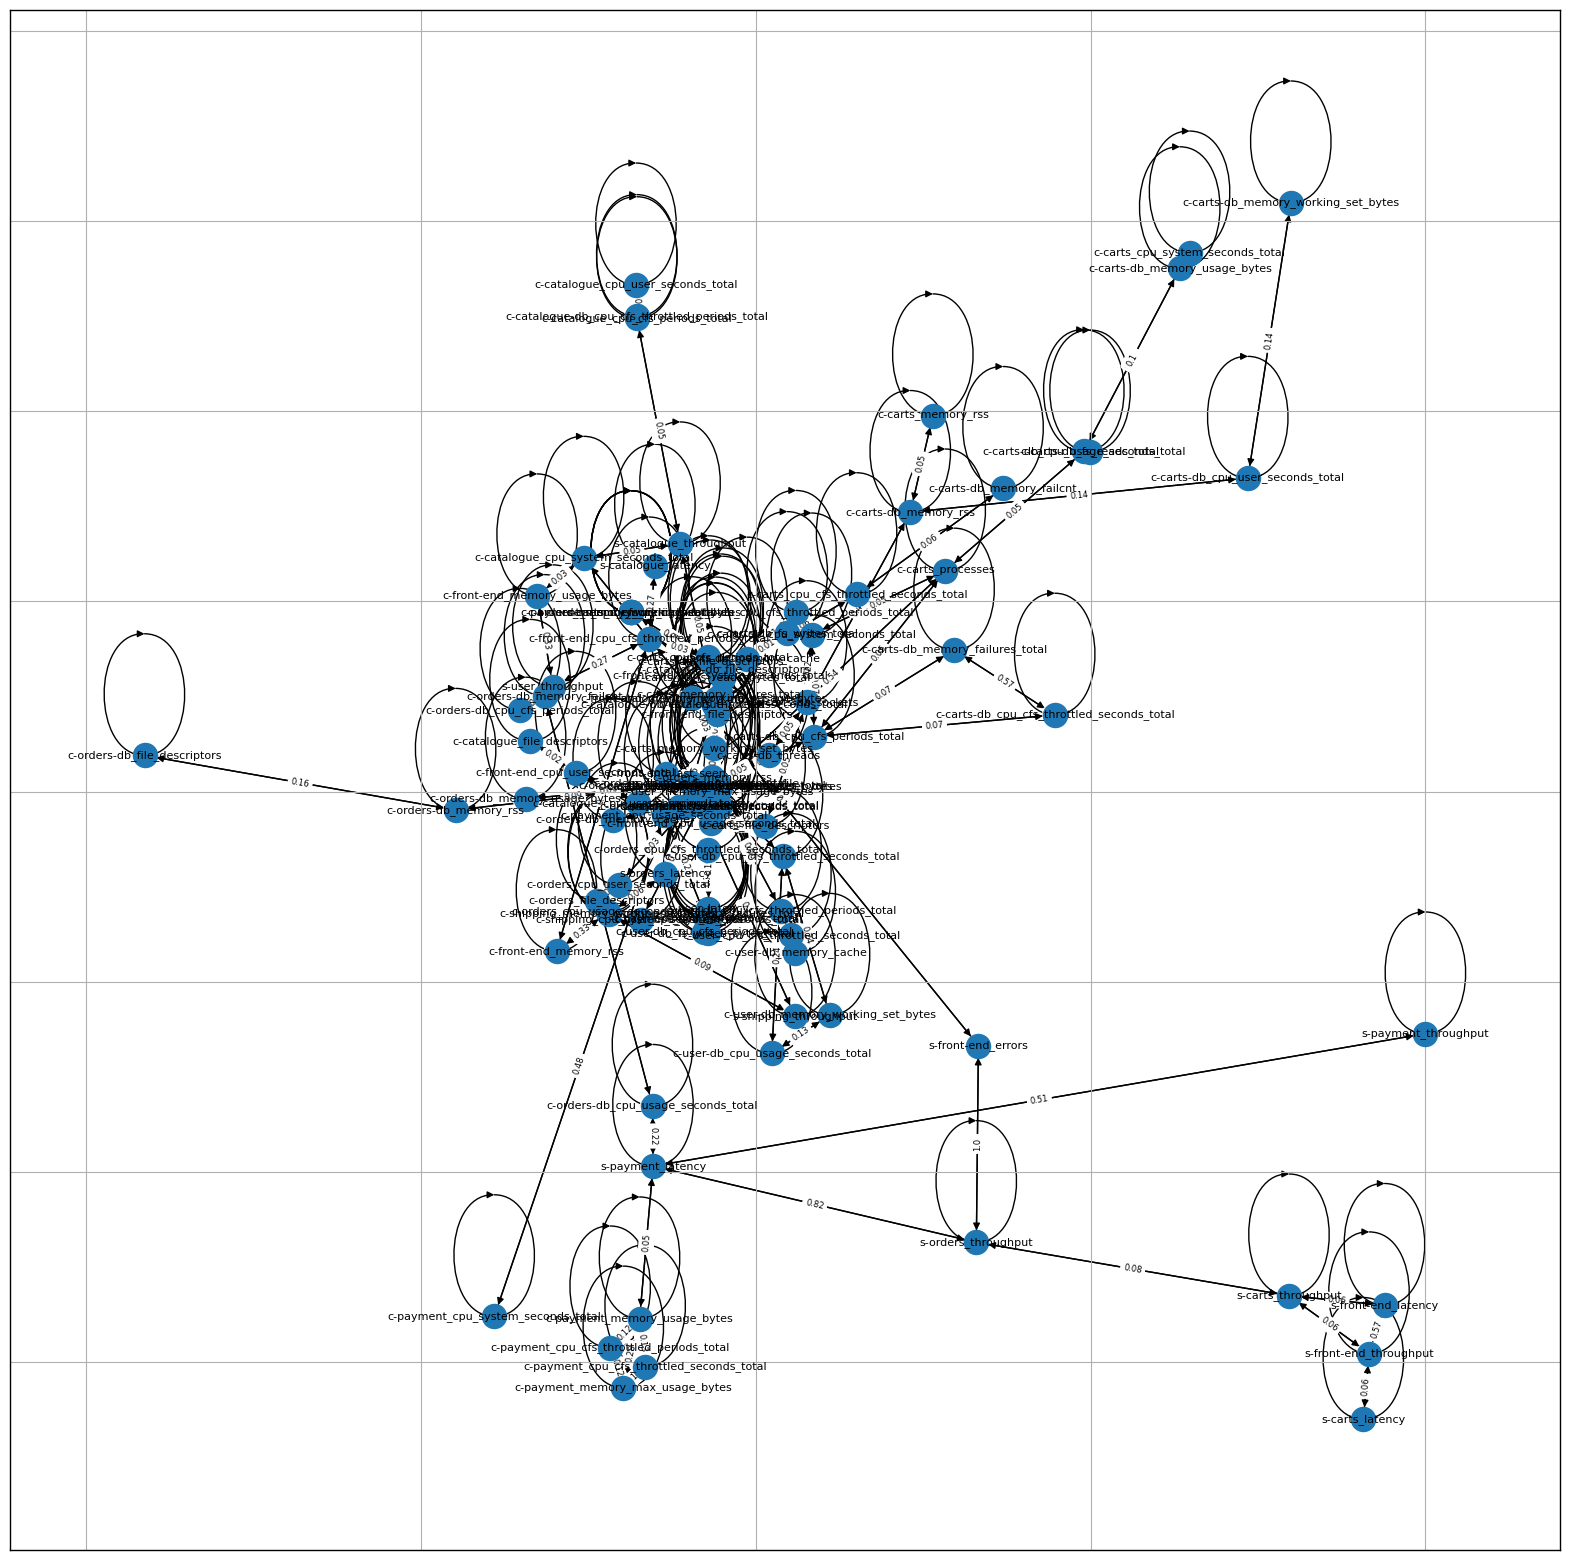

In [126]:
plt.figure(figsize=(20,20))
pos=nx.kamada_kawai_layout(g)
nx.draw_networkx(g, pos=pos, font_size=8)
# nx.set_edge_attributes(g, {(e[0], e[1]): {'label': e[2]['weight']} for e in g.edges(data=True)})
labels = {k: round(v, 2) for k, v in nx.get_edge_attributes(g, 'weight').items()}
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels, font_size=6)
plt.show()

In [127]:
ranks = pagerank(g, record)
pd.DataFrame(ranks, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "chaos_case_num", "metric_name", "metric_values", "pagerank"]).sort_values("pagerank", ascending=False).head(n=15).reset_index()

,index,dataset_id,target_app,chaos_type,chaos_comp,chaos_case_num,metric_name,metric_values,pagerank
0,104,9n6mf,sock-shop,pod-cpu-hog,carts,0,s-orders_latency,"[0.0232, 0.0243, 0.024, 0.0237, 0.0242, 0.0239...",0.025860
1,109,9n6mf,sock-shop,pod-cpu-hog,carts,0,s-shipping_throughput,"[31.2444, 31.6444, 31.8444, 31.6222, 31.1556, ...",0.023132
2,77,9n6mf,sock-shop,pod-cpu-hog,carts,0,c-payment_cpu_usage_seconds_total,"[0.0182, 0.0179, 0.0137, 0.0178, 0.0179, 0.017...",0.022501
3,108,9n6mf,sock-shop,pod-cpu-hog,carts,0,s-shipping_latency,"[0.0011, 0.0016, 0.0017, 0.0017, 0.0014, 0.001...",0.021680
4,29,9n6mf,sock-shop,pod-cpu-hog,carts,0,c-catalogue-db_cpu_cfs_throttled_periods_total,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.019341
5,7,9n6mf,sock-shop,pod-cpu-hog,carts,0,c-carts-db_fs_reads_bytes_total,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.019129
6,16,9n6mf,sock-shop,pod-cpu-hog,carts,0,c-carts-db_sockets,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....",0.017943
7,106,9n6mf,sock-shop,pod-cpu-hog,carts,0,s-payment_latency,"[0.0004, 0.0003, 0.0004, 0.0004, 0.0004, 0.000...",0.017558
8,84,9n6mf,sock-shop,pod-cpu-hog,carts,0,c-shipping_memory_working_set_bytes,"[463724544.0, 463720448.0, 463720448.0, 463724...",0.017207
9,111,9n6mf,sock-shop,pod-cpu-hog,carts,0,s-user_throughput,"[243.8889, 244.0667, 243.0222, 243.1111, 240.1...",0.017178


# Refactored code

In [49]:
DATASET_ID = "9n6mf"
datasets_hdbscan_sbd = load_tsdr_by_chaos(
    DATASET_ID, suffix="hdbscan_sbd_only_ctnrs", revert_normalized_time_series=True,
)

In [20]:
from diagnoser import diag

from notebooklib.plot import plot_causal_graph, plot_rank_dataframe
from notebooklib.rank import create_rank_as_dataframe

In [136]:
record, data_df_by_metric_type = datasets_hdbscan_sbd[("pod-cpu-hog", "user")][0]
cg, ranks = diag.build_and_walk_causal_graph(
    pd.concat([
        data_df_by_metric_type["services"][-1],
        data_df_by_metric_type["containers"][-1],
    ], axis=1),
    record.pk, 
    use_call_graph=True,
    pc_library="cdt",
    pc_citest_alpha=0.05,
    pc_citest="fisher-z",
    pc_variant="stable",
    disable_orientation=False,
    walk_method="monitorrank",
    root_metric_type="latency",
)

In [141]:
rank_df = create_rank_as_dataframe(ranks, DATASET_ID, record)
rank_df

,index,dataset_id,target_app,chaos_type,chaos_comp,chaos_idx,metric_name,cause(mandatory),cause(optional),rank,metric_values
1,0,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user-db_memory_usage_bytes,False,False,0.033800,"[135651328.0, 135512064.0, 135540736.0, 135495..."
2,1,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user-db_memory_working_set_bytes,False,False,0.033387,"[105259008.0, 105119744.0, 105148416.0, 105103..."
3,2,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user-db_memory_rss,False,False,0.032917,"[51634176.0, 51769344.0, 51769344.0, 51769344...."
4,3,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user-db_cpu_user_seconds_total,False,False,0.023329,"[0.0899, 0.091, 0.0908, 0.0918, 0.0894, 0.092,..."
5,4,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user-db_cpu_usage_seconds_total,False,False,0.022693,"[0.1338, 0.1344, 0.1349, 0.1359, 0.134, 0.1349..."
6,5,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user-db_last_seen,False,False,0.018611,"[1676696147.0, 1676696162.0, 1676696177.0, 167..."
7,6,9n6mf,sock-shop,pod-cpu-hog,user,0,c-carts-db_cpu_cfs_throttled_periods_total,False,False,0.016328,"[0.0444, 0.0558, 0.0636, 0.0646, 0.3231, 0.404..."
8,7,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user_cpu_cfs_throttled_periods_total,False,True,0.015837,"[0.0, 0.0, 0.0, 0.0, 0.08, 0.0924, 0.0929, 0.0..."
9,8,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user_memory_rss,False,True,0.015772,"[12435456.0, 12435456.0, 12435456.0, 12435456...."
10,9,9n6mf,sock-shop,pod-cpu-hog,user,0,c-user_threads,True,True,0.015756,"[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16...."


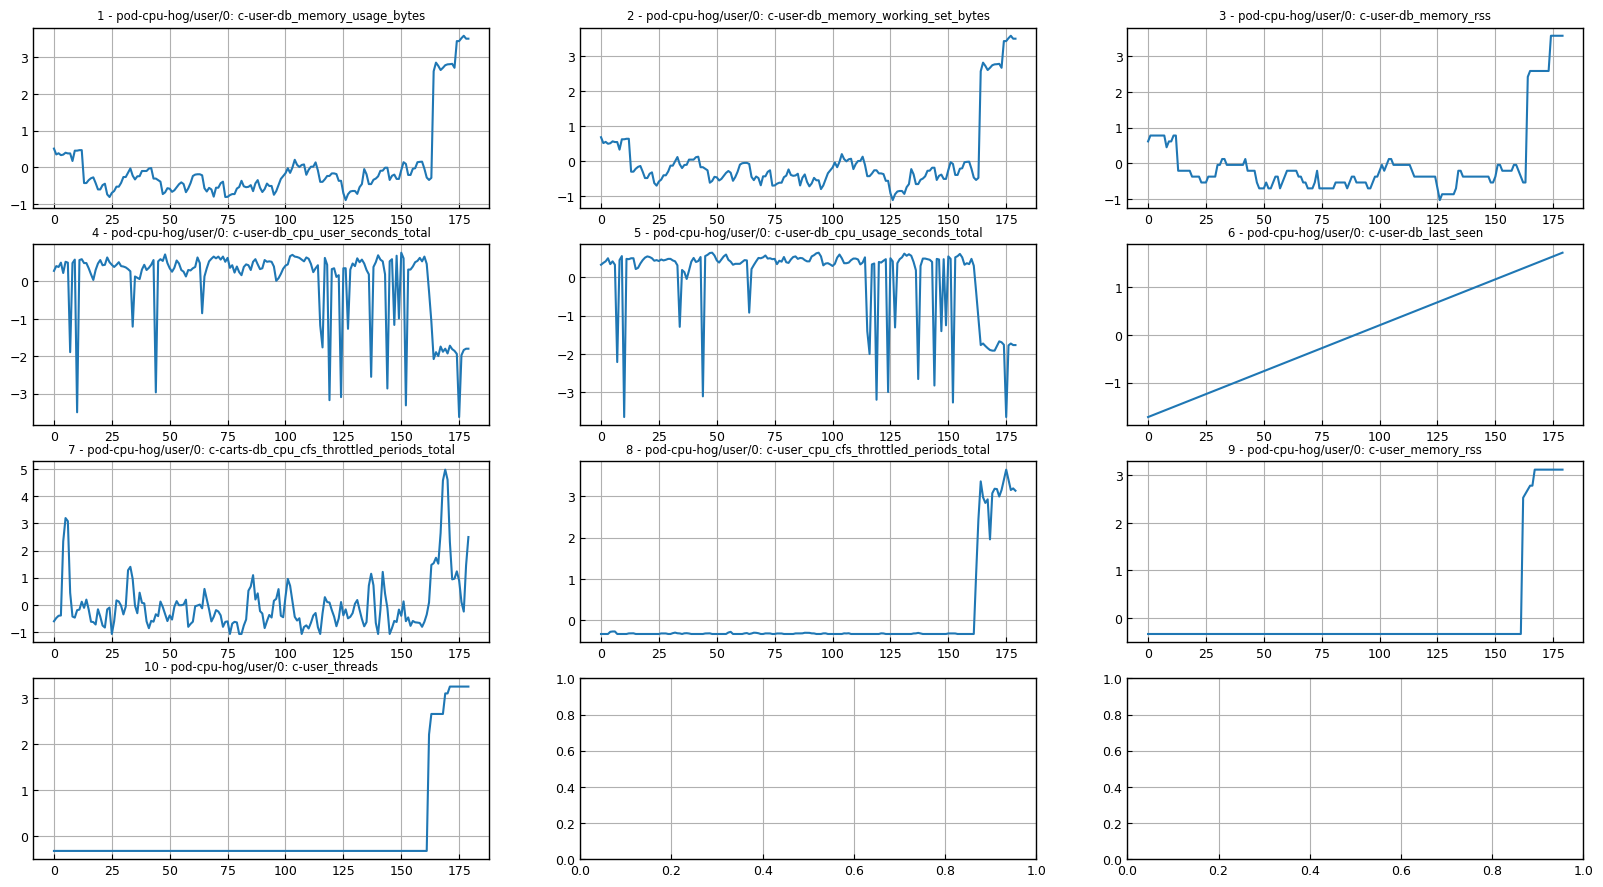

In [160]:
plot_rank_dataframe(rank_df)

In [135]:
plot_causal_graph(cg)

KeyboardInterrupt: 